## Imports

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import cv2
from skimage.feature import local_binary_pattern
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
import joblib

## Functions

In [15]:
def extract_lbp_features(image):
    num_points = 24
    radius = 3
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Extrahiere die LBP-Merkmale aus dem Graustufenbild
    lbp = local_binary_pattern(gray_image, num_points, radius, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, num_points + 3), range=(0, num_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return hist

def extract_hog_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Create a HOG detector with customized parameters
    winSize = (64, 64)
    blockSize = (32, 32)  
    blockStride = (16, 16)
    cellSize = (16, 16)
    nbins = 9
    hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)
    # Extract the HOG features
    hog_features = hog.compute(gray_image)
    return hog_features

def predict_image_HOG(image, classifier, hog_pca_transformer):
    predict_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Verkleinere das Bild
    predict_resized_image = cv2.resize(predict_image, (255, 255))
    # Extrahiere die HOG-Merkmale
    hog_features = extract_hog_features(predict_resized_image)
    hog_features_pca = hog_pca_transformer.transform(hog_features.reshape(1, -1))
  # Führe die Vorhersage mit dem Klassifikator durch
    probabilities = classifier.predict_proba(hog_features_pca)[0]
    predicted_class_index = np.argmax(probabilities)
    predicted_class_name = classifier.classes_[predicted_class_index]
    confidence = probabilities[predicted_class_index]
    return predicted_class_name, confidence

def predict_image_LBP(image, classifier):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Verkleinere das Bild
    resized_image = cv2.resize(image, (255, 255))
    # Extrahiere die LBP-Merkmale
    lbp_features = extract_lbp_features(resized_image)
    # Führe die Vorhersage mit dem Klassifikator durch
    prediction = classifier.predict([lbp_features])[0]
    # Bestimme die Vertrauenswahrscheinlichkeit für die Vorhersage
    confidence = max(classifier.predict_proba([lbp_features])[0])
    return prediction, confidence
    
def detect_face(image_path):
    # Laden des Gesichtserkennungs-Klassifikators (Haar-Cascade)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    # Laden des Bildes
    image = cv2.imread(image_path)
    if image is not None:
        # Konvertieren des Bildes in Graustufen
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Gesichter im Bild erkennen
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(200, 200))
        if len(faces) > 0:
            # Nehme das erste erkannte Gesicht
            (x, y, w, h) = faces[0]
            # Schneide das Gesicht aus
            face = image[y:y+h, x:x+w]
             # Zeichne ein Rechteck um das erkannte Gesicht
            ##cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
            return face
        else:
            print(f"No face detected in {image_path}")
            return None
    else:
        print(f"Failed to load image: {image_path}")
        return None

# Laden der Bilder und Extrahieren der Merkmale
def load_images_and_extract_features(data_folder, feature_extractor):
    features = []
    labels = []
    for folder_name in os.listdir(data_folder):
        folder_path = os.path.join(data_folder, folder_name)
        if os.path.isdir(folder_path):
            for file_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, file_name)
                face = detect_face(image_path)
                if face is not None:
                    # Convert the image from BGR to RGB
                    rgb_face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
                    resized_face = cv2.resize(rgb_face, (255, 255))
                    feature = feature_extractor(resized_face)
                    features.append(feature)
                    labels.append(folder_name)
                else:
                    print(f"Failed to detect face in image: {image_path}")
    return np.array(features), np.array(labels)

def apply_pca(features, variance_threshold):
    pca = PCA(n_components = variance_threshold, svd_solver='full')
    pca.fit(features)
    features_reduced = pca.transform(features)
    return features_reduced, pca

# Funktion zur Berechnung des Durchschnitts der Merkmale für jede Klasse
def calculate_average_features_by_class(features, labels):
    features_by_class = {}
    class_counts = {}

    # Iteration über Merkmale und Labels
    for feature, label in zip(features, labels):
        if label not in features_by_class:
            features_by_class[label] = [feature]
            class_counts[label] = 1
        else:
            features_by_class[label].append(feature)
            class_counts[label] += 1

    # Berechnung des Durchschnitts der Merkmale für jede Klasse
    average_features = []
    class_labels = []

    for label, features_list in features_by_class.items():
        average_feature = np.mean(features_list, axis=0)
        average_features.append(average_feature)
        class_labels.append(label)

    return np.array(average_features), np.array(class_labels), class_counts





## Face detection auf zu trainierenden Bildern

In [16]:
#Pfad zum Ordner mit den Unterordnern für jede Person
base_path = "Bilder"

# Zielordner für die geschnittenen Gesichter
output_folder = 'Bilder_detected_faces'

# Erstellen des Zielordners, falls er noch nicht existiert
output_path = output_folder
os.makedirs(output_path, exist_ok=True)

# Durchlaufen der Ordner im Basispfad
for person_folder in os.listdir(base_path):
    person_folder_path = os.path.join(base_path, person_folder)
    # Überprüfen, ob es sich um einen Ordner handelt
    if os.path.isdir(person_folder_path):
        # Durchlaufen der Bilder im Unterordner
        for filename in os.listdir(person_folder_path):
            image_path = os.path.join(person_folder_path, filename)
            # Gesichtserkennung durchführen
            face = detect_face(image_path)
            if face is not None:
                # Pfad für das ausgeschnittene Gesicht
                new_folder_path = os.path.join(output_path, person_folder)
                os.makedirs(new_folder_path, exist_ok=True)
                new_image_path = os.path.join(new_folder_path, f"{filename.split('.')[0]}_face.jpg")
                # Speichern des ausgeschnittenen Gesichts als neues Bild
                cv2.imwrite(new_image_path, face)
                print(f"Gesicht in {filename} wurde erfolgreich ausgeschnitten und als {new_image_path} gespeichert.")
            else:
                print(f"Fehler beim Ausschneiden des Gesichts in {filename}.")

print("Gesichtserkennung und Ausschneiden abgeschlossen.")

Gesicht in 20240403_185035.jpg wurde erfolgreich ausgeschnitten und als Bilder_detected_faces\Nino\20240403_185035_face.jpg gespeichert.
Gesicht in 20240403_185045.jpg wurde erfolgreich ausgeschnitten und als Bilder_detected_faces\Nino\20240403_185045_face.jpg gespeichert.
Gesicht in 20240403_185047.jpg wurde erfolgreich ausgeschnitten und als Bilder_detected_faces\Nino\20240403_185047_face.jpg gespeichert.
Gesicht in 20240403_185056.jpg wurde erfolgreich ausgeschnitten und als Bilder_detected_faces\Nino\20240403_185056_face.jpg gespeichert.
Gesicht in 20240403_185058.jpg wurde erfolgreich ausgeschnitten und als Bilder_detected_faces\Nino\20240403_185058_face.jpg gespeichert.
Gesicht in 20240403_185115.jpg wurde erfolgreich ausgeschnitten und als Bilder_detected_faces\Nino\20240403_185115_face.jpg gespeichert.
Gesicht in 20240403_1851150.jpg wurde erfolgreich ausgeschnitten und als Bilder_detected_faces\Nino\20240403_1851150_face.jpg gespeichert.
Gesicht in 20240403_185146.jpg wurde er

## Erstelle Augmented Bilder

In [17]:
# Define the path to the dataset folder
data_folder = "Bilder_detected_faces"

# Liste zum Speichern der Bilder und ihrer Labels
augmented_images = []
augmented_labels = []

# Iterate over the folders in the dataset folder
for folder_name in os.listdir(data_folder):
    folder_path = os.path.join(data_folder, folder_name)
    # Check if the item is a folder
    if os.path.isdir(folder_path):
        # Iterate over the files in the folder
        for file_name in os.listdir(folder_path):
            # Assuming the files are image files, you can adjust the file type according to your dataset
            # Read the image using OpenCV
            if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_path = os.path.join(folder_path, file_name)
                image = cv2.imread(image_path)
                # Check if the image is loaded successfully
                if image is not None:
                    # Convert the image from BGR to RGB
                    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    # Resize the image to a desired size
                    resized_image = cv2.resize(rgb_image, (255, 255))
                    # Perform image augmentation using Keras ImageDataGenerator
                    datagen = ImageDataGenerator(
                        rotation_range=20,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True,
                        fill_mode='constant'
                    )
                    # Reshape the image to add batch dimension
                    reshaped_image = resized_image.reshape((1,) + resized_image.shape)
                    # Generate augmented images and append to the list
                    i = 0
                    for batch in datagen.flow(reshaped_image, batch_size=1):
                        augmented_image = batch[0].astype(np.uint8)
                        augmented_images.append(augmented_image)
                        augmented_labels.append(folder_name)  # Hinzufügen des Labels (Ordnername)
                        i += 1
                        if i >= 200:
                            break  # Break the loop after generating 100 augmented images
                else:
                    print(f"Failed to load image: {image_path}")
            else:
                print(f"Skipping non-image file: {file_name}")

# Ausgabe der Anzahl der geladenen Bilder
print(f"Total images: {len(augmented_images)}")
print(f"Total labels: {len(augmented_labels)}")

Total images: 11200
Total labels: 11200


## Hog Training Feature Extraction

In [18]:
# Initialize empty lists to store HOG features and labels
hog_features = []
hog_labels = []

# Iterate over the images and labels in the lists
for image, label in zip(augmented_images, augmented_labels):
    hog_feature = extract_hog_features(image)
    # Add the HOG feature to the list of features
    hog_features.append(np.array(hog_feature))
    # Add the label to the list of labels
    hog_labels.append(label)
    # Print HOG features and label
    print(f"HOG features: {hog_feature}, Label: {label}")

hog_features_array = np.array(hog_features)
hog_features_reshaped = hog_features_array.reshape(len(hog_features), -1)
hog_features, hog_pca_transformer = apply_pca(hog_features_reshaped, 0.95)
print(f"Total HOG features: {len(hog_features)}")
print(f"Total labels: {len(hog_labels)}")

# Dateipfad, um den PCA-Transformer zu speichern
hog_pca_transformer_path = "hog_pca_transformer.pkl"
# Speichern des trainierten PCA-Transformers
joblib.dump(hog_pca_transformer, hog_pca_transformer_path)

HOG features: [0.26325378 0.28247842 0.13702989 ... 0.00050626 0.00068265 0.05840919], Label: Nino
HOG features: [0.         0.         0.         ... 0.11310679 0.11216989 0.15469411], Label: Nino
HOG features: [0.         0.         0.         ... 0.11309055 0.13296174 0.11350816], Label: Nino
HOG features: [0.         0.         0.         ... 0.10412098 0.19170032 0.26596788], Label: Nino
HOG features: [0.         0.         0.         ... 0.20723498 0.20840909 0.13957874], Label: Nino
HOG features: [0. 0. 0. ... 0. 0. 0.], Label: Nino
HOG features: [0.         0.         0.         ... 0.10008685 0.10326013 0.19066304], Label: Nino
HOG features: [0.28205696 0.1738178  0.12994686 ... 0.         0.         0.        ], Label: Nino
HOG features: [0.25562665 0.2113678  0.13519064 ... 0.07403793 0.08453029 0.1653263 ], Label: Nino
HOG features: [0.         0.         0.         ... 0.14647073 0.13239259 0.16718599], Label: Nino
HOG features: [0. 0. 0. ... 0. 0. 0.], Label: Nino
HOG fea

['hog_pca_transformer.pkl']

## LBP Training Feature Extraction

In [19]:
# Initialize empty lists to store LBP features
lbp_features = []
lbp_labels = []

# Iterate over the images and labels in the lists
for image, label in zip(augmented_images, augmented_labels):
    # Extract LBP features
    lbp_feature = extract_lbp_features(image)
    # Flatten the LBP feature array and append to the list of features
    lbp_features.append(lbp_feature)
    # Add the label to the list of labels
    lbp_labels.append(label)
    # Print LBP features and label

    print(f"LBP features: {lbp_feature}, Label: {label}")


#lbp_features_array = np.array(lbp_features)
#lbp_features_reshaped = lbp_features_array.reshape(len(lbp_features), -1)
#anzahl_samples = lbp_features_reshaped.shape[0]
#print("Anzahl der Samples:", anzahl_samples)
print(f"Total LBP features: {len(lbp_features)}")
print(f"Total labels: {len(lbp_labels)}")

LBP features: [0.03952326 0.02205306 0.01608612 0.01225682 0.01044214 0.00978085
 0.00918108 0.01044214 0.01356401 0.01779316 0.0253441  0.03498654
 0.04195309 0.03713956 0.02425221 0.01857747 0.01190311 0.00962707
 0.00816609 0.00793541 0.00908881 0.01230296 0.01679354 0.02008458
 0.15504806 0.40567474], Label: Nino
LBP features: [0.03535563 0.01940792 0.01430219 0.01004229 0.00799692 0.00784314
 0.00864283 0.00893502 0.01081123 0.0141484  0.01903883 0.02994233
 0.03578624 0.03112649 0.01902345 0.01437908 0.00971934 0.0083045
 0.00650519 0.00678201 0.00753556 0.01004229 0.01337947 0.01762399
 0.28039985 0.3529258 ], Label: Nino
LBP features: [0.03554018 0.01925413 0.0132872  0.01042676 0.00887351 0.00841215
 0.00865821 0.00931949 0.01113418 0.0149481  0.0203614  0.02932718
 0.03537101 0.03080354 0.02074587 0.01513264 0.01002691 0.00884275
 0.00675125 0.00739715 0.00762784 0.010396   0.01391772 0.01860823
 0.26666667 0.35816993], Label: Nino
LBP features: [0.03304883 0.01882353 0.01151

## Random Forest LBP

In [20]:
## lbp Random Forest
# Laden der Trainingsdaten für LBP
X_train_lbp = lbp_features
y_train_lbp = lbp_labels

# Laden der Testdaten für LBP
X_test_lbp, y_test_lbp = load_images_and_extract_features("Test", lambda img: extract_lbp_features(img))

# Initialisierung des Random-Forest-Klassifikators
rf_classifier_lbp = RandomForestClassifier(n_estimators=700, max_depth=20, random_state=42, n_jobs=-1, verbose=0 , max_features='sqrt', criterion='gini')
 
# Durchführung der Kreuzvalidierung mit 5 Faltungen
cv_scores_lbp = cross_val_score(rf_classifier_lbp, X_train_lbp, y_train_lbp, cv=5)

# Trainieren des Random-Forest-Modells auf dem gesamten Trainingsdatensatz
rf_classifier_lbp.fit(X_train_lbp, y_train_lbp)
 
# Evaluierung des Modells auf den Testdaten für LBP
accuracy_lbp = rf_classifier_lbp.score(X_test_lbp, y_test_lbp)
predicted_lbp = rf_classifier_lbp.predict(X_test_lbp)

# Ausgabe der Ergebnisse
print("Cross-Validation Scores lbp:", cv_scores_lbp)
print("Mean Accuracy (Cross-Validation) lbp:", cv_scores_lbp.mean())
print("Accuracy (Test Set) lbp:", accuracy_lbp)
print("Predicted (Test Set) lbp:", predicted_lbp)

Cross-Validation Scores lbp: [0.75       0.68705357 0.67723214 0.76785714 0.61473214]
Mean Accuracy (Cross-Validation) lbp: 0.6993749999999999
Accuracy (Test Set) lbp: 0.6666666666666666
Predicted (Test Set) lbp: ['Nino' 'Nino' 'Nino' 'Nino' 'Nino' 'Nino' 'Nino' 'Nino' 'Robin' 'Nino'
 'Nino' 'Robin']


## Random Forest hog

In [21]:
## HOG Randon Forest
X_train_hog = hog_features
y_train_hog = hog_labels

# Laden der Testdaten für HOG
X_test_hog, y_test_hog = load_images_and_extract_features("Test", lambda img: extract_hog_features(img))

print(f"Total HOG features: {len(X_train_hog)}")
# Initialisierung des Random-Forest-Klassifikators
rf_classifier_hog = RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42, n_jobs=-1, verbose=0, max_features='sqrt', criterion= 'entropy')

# Durchführung der Kreuzvalidierung mit 5 Faltungen
cv_scores = cross_val_score(rf_classifier_hog, X_train_hog, y_train_hog, cv=5)

# Trainieren des Random-Forest-Modells auf dem gesamten Trainingsdatensatz
rf_classifier_hog.fit(X_train_hog, y_train_hog)

# Classifiers speichern
rf_classifier_hog_path = "rf_classifier_hog.pkl"
joblib.dump(rf_classifier_hog, rf_classifier_hog_path)
# Iteration über jedes Bild im Testdatensatz und Klassifizierung
correct_predictions = 0
for i, image in enumerate(X_test_hog):
    # Anwenden des PCA-Transformers auf das Bild
    image_pca = hog_pca_transformer.transform(image.reshape(1, -1))
    # Durchführen der Vorhersage mit dem trainierten Modell
    prediction = rf_classifier_hog.predict(image_pca)
    # Ausgabe der Vorhersage für jedes Bild
    print(f"Prediction for image {i+1}: {prediction}")
    if prediction == y_test_hog[i]:
        correct_predictions += 1
    # Berechnung der Genauigkeit
    accuracy = correct_predictions / len(y_test_hog)


# Ausgabe der Ergebnisse
print("Cross-Validation Scores hog:", cv_scores)
print("Mean Accuracy (Cross-Validation) hog:", cv_scores.mean())
print(f"Accuracy: {accuracy}")


Total HOG features: 11200
Prediction for image 1: ['Nino']
Prediction for image 2: ['Nino']
Prediction for image 3: ['Robin']
Prediction for image 4: ['Nino']
Prediction for image 5: ['Nino']
Prediction for image 6: ['Nino']
Prediction for image 7: ['Robin']
Prediction for image 8: ['Robin']
Prediction for image 9: ['Robin']
Prediction for image 10: ['Robin']
Prediction for image 11: ['Robin']
Prediction for image 12: ['Robin']
Cross-Validation Scores hog: [0.79732143 0.62232143 0.66830357 0.61696429 0.66919643]
Mean Accuracy (Cross-Validation) hog: 0.6748214285714286
Accuracy: 0.9166666666666666


## Bilder predicten

## Hog

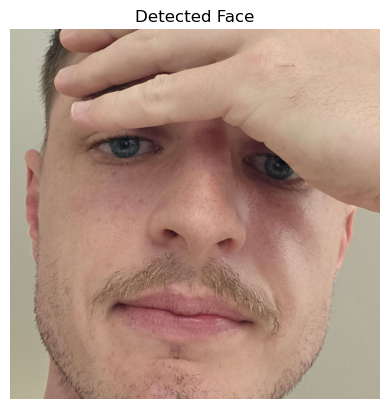

Prediction HOG for 20240326_154707.jpg: Robin, Confidence: 0.5399763703020005


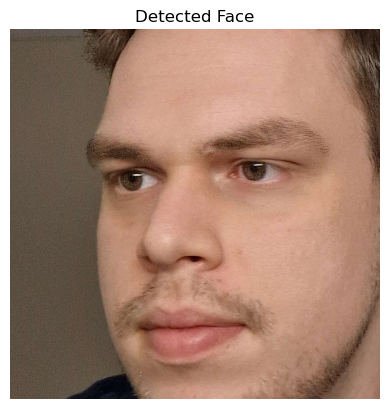

Prediction HOG for 20240403_1850360.jpg: Nino, Confidence: 0.5645051659464135


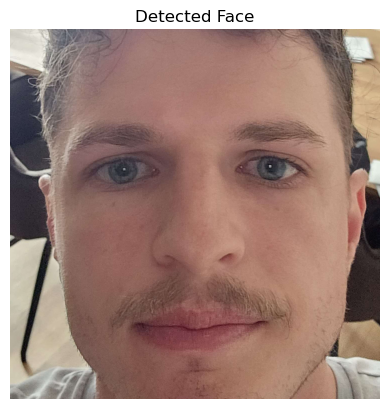

Prediction HOG for 20240403_192357.jpg: Robin, Confidence: 0.5194885132723809


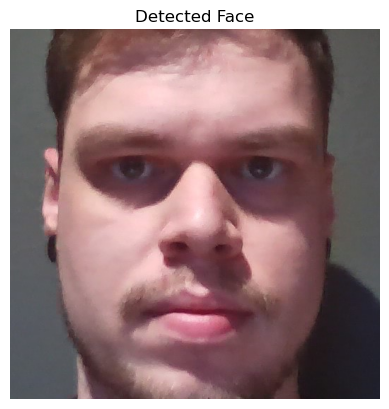

Prediction HOG for image (1).jpg: Nino, Confidence: 0.5392814996500516


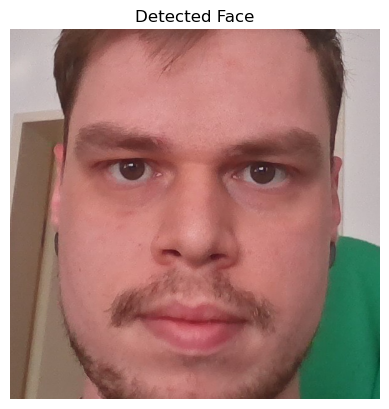

Prediction HOG for image (2).jpg: Nino, Confidence: 0.5796525410278803


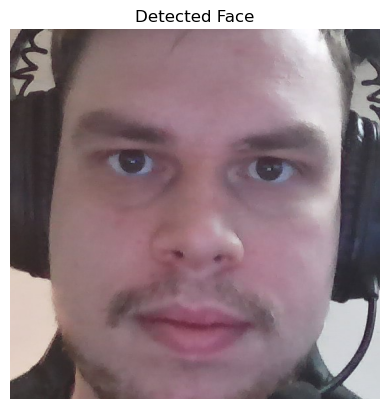

Prediction HOG for image (3).jpg: Nino, Confidence: 0.5448264218952616


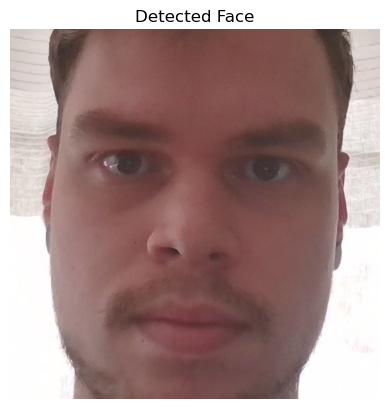

Prediction HOG for image (4).jpg: Nino, Confidence: 0.5328574159348306


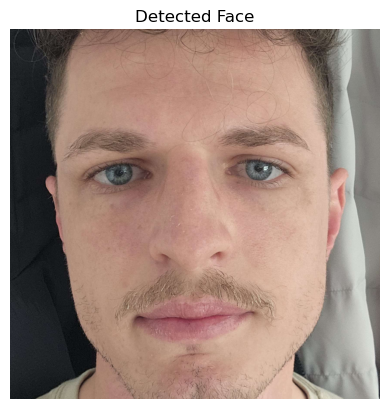

Prediction HOG for robin191.jpg: Robin, Confidence: 0.544647605035436


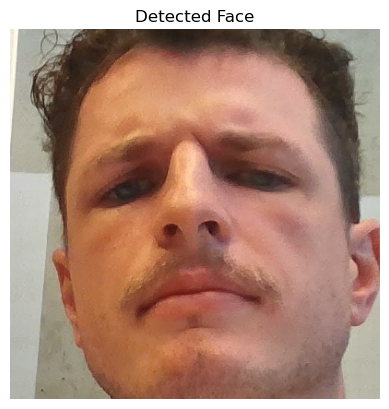

Prediction HOG for robin7.jpg: Robin, Confidence: 0.5725083793863428


In [22]:
# Ordnerpfad mit den zu klassifizierenden Bildern
predict_folder = "predict"

# Iteriere über die Bilder im Ordner und führe die Vorhersage durch
for filename in os.listdir(predict_folder):
    image_path = os.path.join(predict_folder, filename)
    # Gesichtserkennung durchführen
    face = detect_face(image_path)
    if face is not None:
        # Plotte das Originalbild mit dem markierten Gesicht
        plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('Detected Face')
        plt.show()

    # Vorhersage mit HOG durchführen
        prediction, confidence = predict_image_HOG(face, rf_classifier_hog, hog_pca_transformer)
        if prediction is not None:
            print(f"Prediction HOG for {filename}: {prediction}, Confidence: {confidence}")

    else:
        print(f"Failed to detect face in {filename}")

## LBP

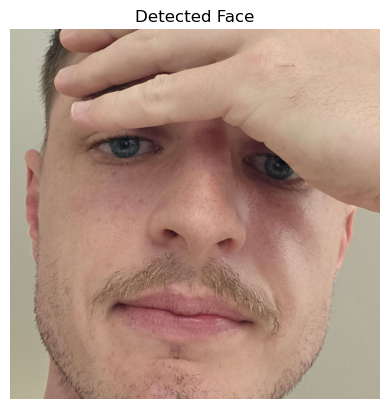

Prediction LBP for 20240326_154707.jpg: Nino, Confidence: 0.7842857142857143


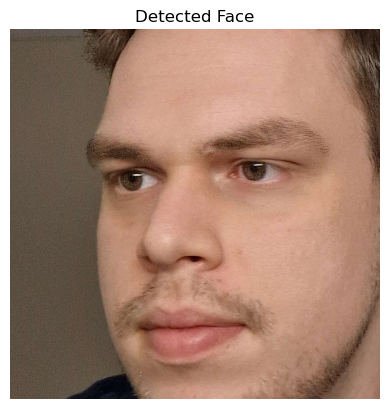

Prediction LBP for 20240403_1850360.jpg: Nino, Confidence: 0.9214285714285714


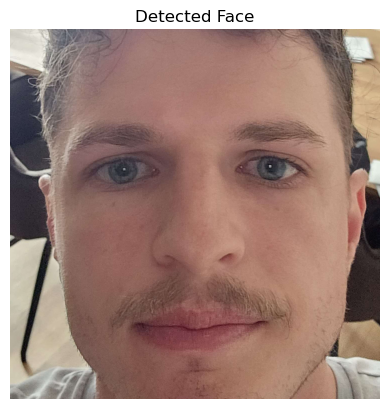

Prediction LBP for 20240403_192357.jpg: Nino, Confidence: 0.8442857142857143


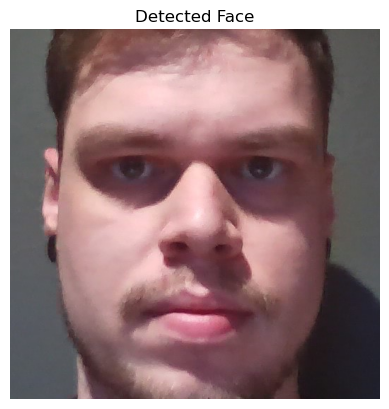

Prediction LBP for image (1).jpg: Nino, Confidence: 0.51


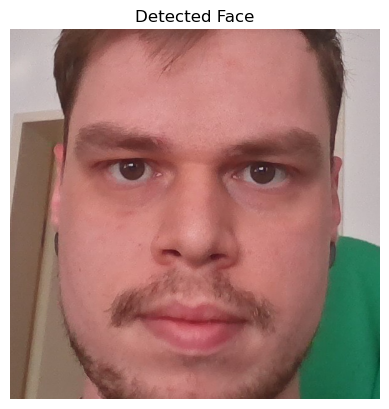

Prediction LBP for image (2).jpg: Robin, Confidence: 0.5328571428571428


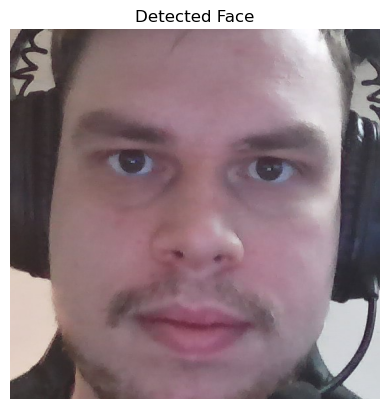

Prediction LBP for image (3).jpg: Robin, Confidence: 0.7213776595744681


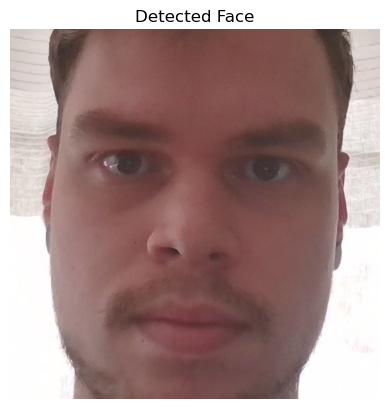

Prediction LBP for image (4).jpg: Robin, Confidence: 0.59


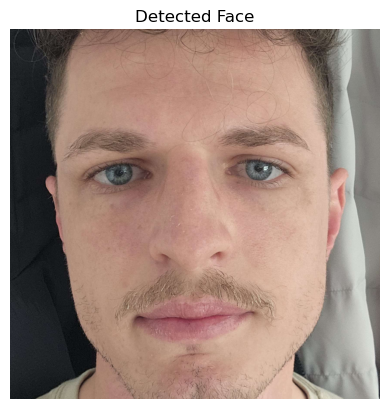

Prediction LBP for robin191.jpg: Nino, Confidence: 0.9257142857142857


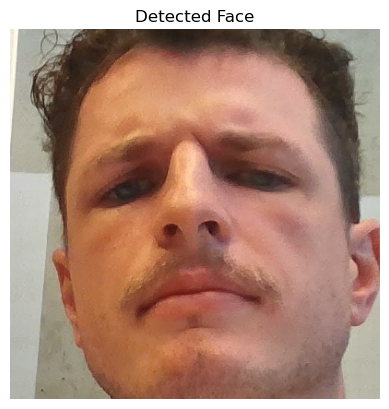

Prediction LBP for robin7.jpg: Robin, Confidence: 0.705


In [23]:
# Ordnerpfad mit den zu klassifizierenden Bildern
predict_folder = "predict"

# Iteriere über die Bilder im Ordner und führe die Vorhersage durch
for filename in os.listdir(predict_folder):
    image_path = os.path.join(predict_folder, filename)
    # Gesichtserkennung durchführen
    face = detect_face(image_path)
    if face is not None:
        # Plotte das Originalbild mit dem markierten Gesicht
        plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('Detected Face')
        plt.show()
        
        # Vorhersage mit LBP durchführen
        if rf_classifier_lbp is not None:
            prediction, confidence = predict_image_LBP(face, rf_classifier_lbp)
            if prediction is not None:
                print(f"Prediction LBP for {filename}: {prediction}, Confidence: {confidence}")

    else:
        print(f"Failed to detect face in {filename}")

## Features Visualisieren HOG

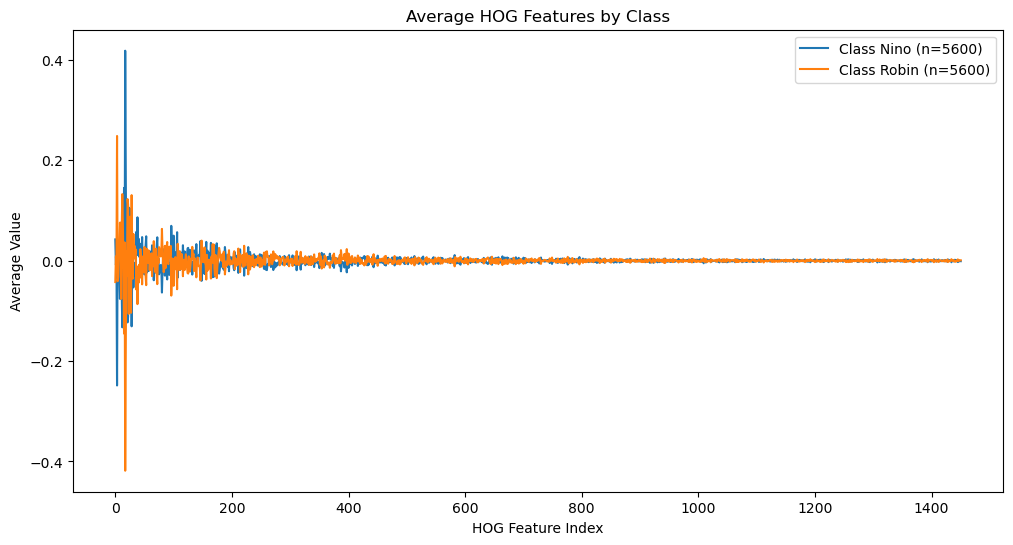

In [24]:
# Berechnung des Durchschnitts der HOG-Merkmale für jede Klasse
average_hog_features_by_class, hog_class_labels, hog_class_counts = calculate_average_features_by_class(hog_features, hog_labels)

# Visualisierung der durchschnittlichen HOG-Merkmale für jede Klasse
plt.figure(figsize=(12, 6))
for i, label in enumerate(hog_class_labels):
    plt.plot(average_hog_features_by_class[i], label=f'Class {label} (n={hog_class_counts[label]})')

plt.xlabel('HOG Feature Index')
plt.ylabel('Average Value')
plt.title('Average HOG Features by Class')
plt.legend()
plt.show()




## Features Visualisieren LBP

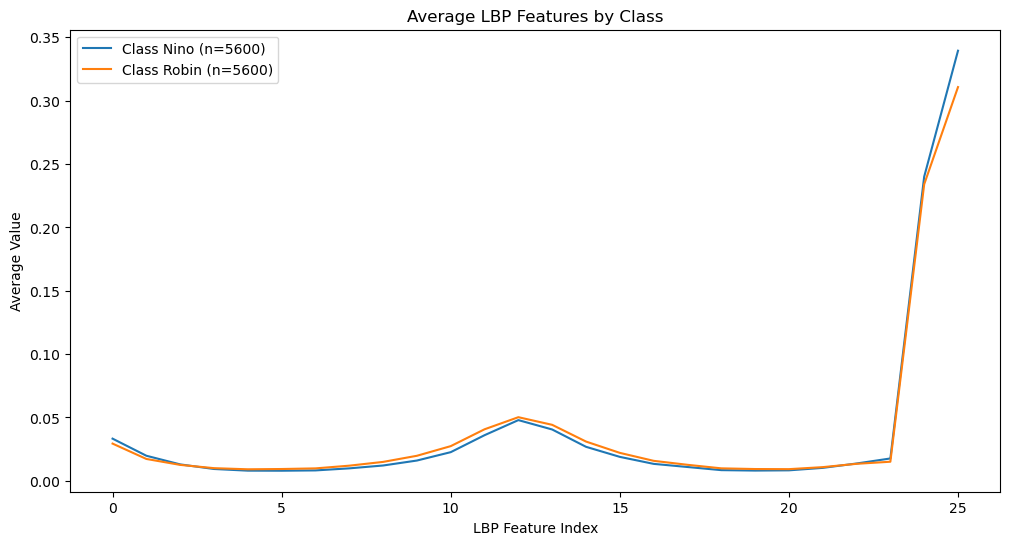

In [25]:
# Berechnung des Durchschnitts der LBP-Merkmale für jede Klasse
average_lbp_features_by_class, lbp_class_labels, lbp_class_counts = calculate_average_features_by_class(lbp_features, lbp_labels)

# Visualisierung der durchschnittlichen LBP-Merkmale für jede Klasse
plt.figure(figsize=(12, 6))
for i, label in enumerate(lbp_class_labels):
    plt.plot(average_lbp_features_by_class[i], label=f'Class {label} (n={lbp_class_counts[label]})')

plt.xlabel('LBP Feature Index')
plt.ylabel('Average Value')
plt.title('Average LBP Features by Class')
plt.legend()
plt.show()